<a href="https://colab.research.google.com/github/L-kiad/DO/blob/main/email_classification_spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> IMPORTING LIBRARIES & DATASET </p>

In [2]:
!pip install optuna --q # For tuning hyperparameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [4]:
!pip install catboost lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.2 MB/s eta 0:00:00


In [5]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
pd.set_option('display.max_columns', None) # code to display all columns

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# libraries for text processing and handling text data
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from collections import Counter

# all the required models
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# for model evaluation
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

# for hyperparameter tuning
import optuna

# to save the required files
import pickle

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

In [6]:
# loading the dataset
df = pd.read_csv('/content/gdrive/MyDrive/mail_datasets/email_spam/completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> INITIAL ANALYSIS </p>

In [7]:
#How big is data?
df.shape

(6046, 3)

In [8]:
# What is the data type of cols?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [9]:
# Are there any missing values?
df.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [10]:
# Are there any duplicate values?
df.duplicated().sum()

0

<div style="color:white;
           display:fill;
           background-color:#562F5E;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Data contains 6046 rows and 3 columns <br>
           2. It has 1 string/object column, and one categorical column in int format <br>
           3. There's only 1 null value present <br>
           4. There are no duplicate values present within data <br>
    </div>

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> FEATURE ENGINEERING </p>

In [11]:
# dropping null values
df.dropna(inplace=True)

In [12]:
# dropping redudant column
df.drop(['Unnamed: 0'],axis=1, inplace=True)

**For the purpose of data exploration, I am creating new features:**

* no_char: Number of characters in the email
* no_words: Number of words in the text email
* no_sent: Number of sentences in the text email

In [14]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
#Adding a column of numbers of charachters,words and sentences in each mail

df['no_char'] = df['Body'].apply(len)
df['no_words'] = df['Body'].apply(lambda x:len(nltk.word_tokenize(x)))
df['no_sent'] = df['Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [16]:
df.head()

,Body,Label,no_char,no_words,no_sent
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> EDA - I </p>

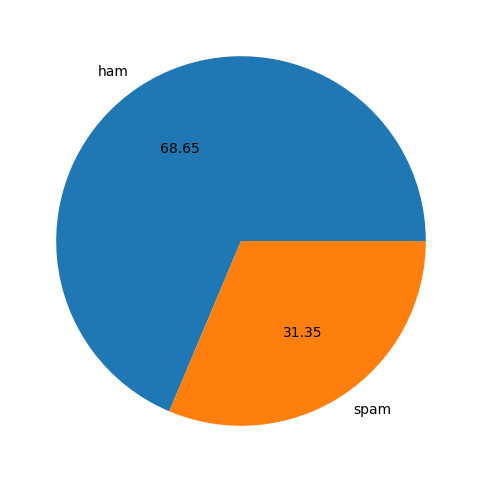

In [17]:
# Let's see the distribution of target variable
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

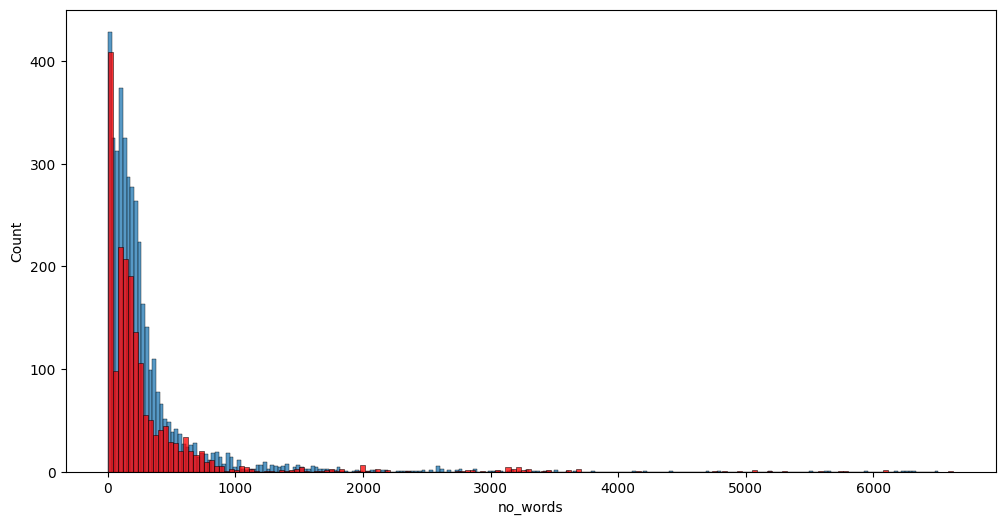

In [18]:
# Lets see the distribution of number of words in spam and ham emails
plt.figure(figsize=(12,6))
sns.histplot(df[df['Label'] == 0]['no_words'])
sns.histplot(df[df['Label'] == 1]['no_words'], color='red')
plt.show()

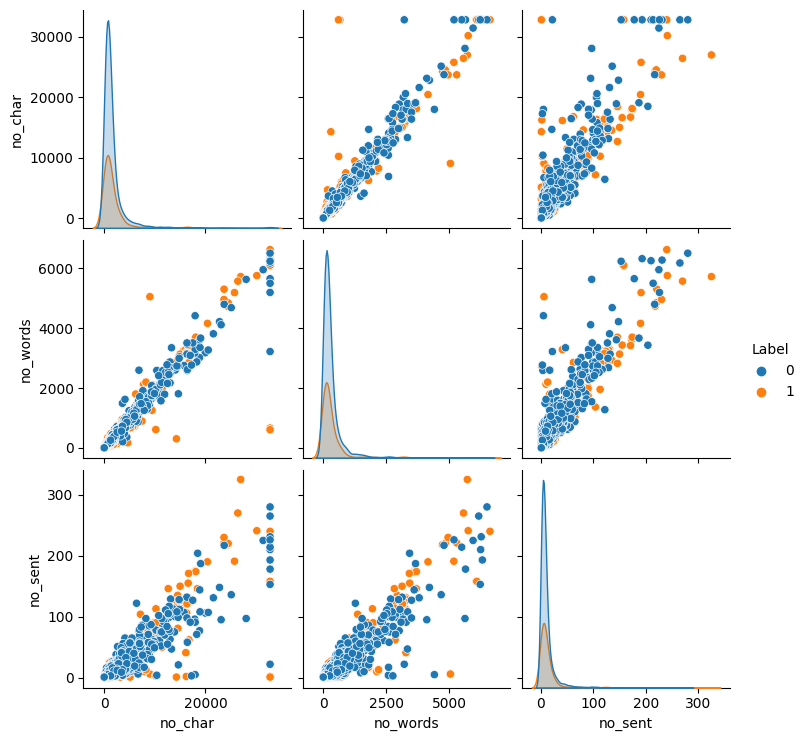

In [19]:
sns.pairplot(df, hue='Label')
plt.show()

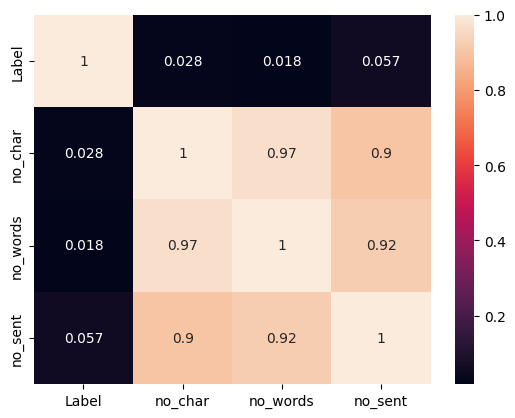

In [20]:
sns.heatmap(df.corr(), annot=True)
plt.show()

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> TEXT PREPROCESSING </p>

Whenever we have textual data, we need to apply several pre-processing steps to the data to transform words into numerical features that work with machine learning algorithms. The pre-processing steps for a problem depend mainly on the domain and the problem itself, hence, we don’t need to apply all steps to every problem.

**for this problem I created a function which performs following steps:**
* Text Lowercase
* Word Tokenize
* Remove Special Characters
* Remove Stopwords
* Remove Punctuation
* Stemming

In [21]:
def text_preprocessing(text):
    # convert  text to lowecase
    text = text.lower()

    # creating list of words in email
    text = nltk.word_tokenize(text)

    # removing special charecters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # copying processed text to text and clearing y to store next steps output
    text = y[:]
    y.clear()

    # removing stopwords and punctuation marks
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    # stemming
    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))

    return " ".join(y)

In [22]:
# applying function to text
df['clean_text'] = df['Body'].apply(text_preprocessing)

In [23]:
df

,Body,Label,no_char,no_words,no_sent,clean_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save 70 life insur spend life quot save ensur ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,1 fight risk cancer http slim guarante lose lb...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,1 fight risk cancer http slim guarante lose lb...
3,##############################################...,1,2863,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,thought might like 1 slim guarante lose lbs 30...
...,...,...,...,...,...,...
6041,empty,0,5,1,1,empti
6042,___ ___ ...,0,16999,3092,91,insignific matter heavili overemphasis hugh mt...
6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0,7299,1478,83,reader write extens search dumb messag revisit...
6044,empty,0,5,1,1,empti


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> EDA - II </p>

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

In [24]:
# setting specs of word cloud image
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')

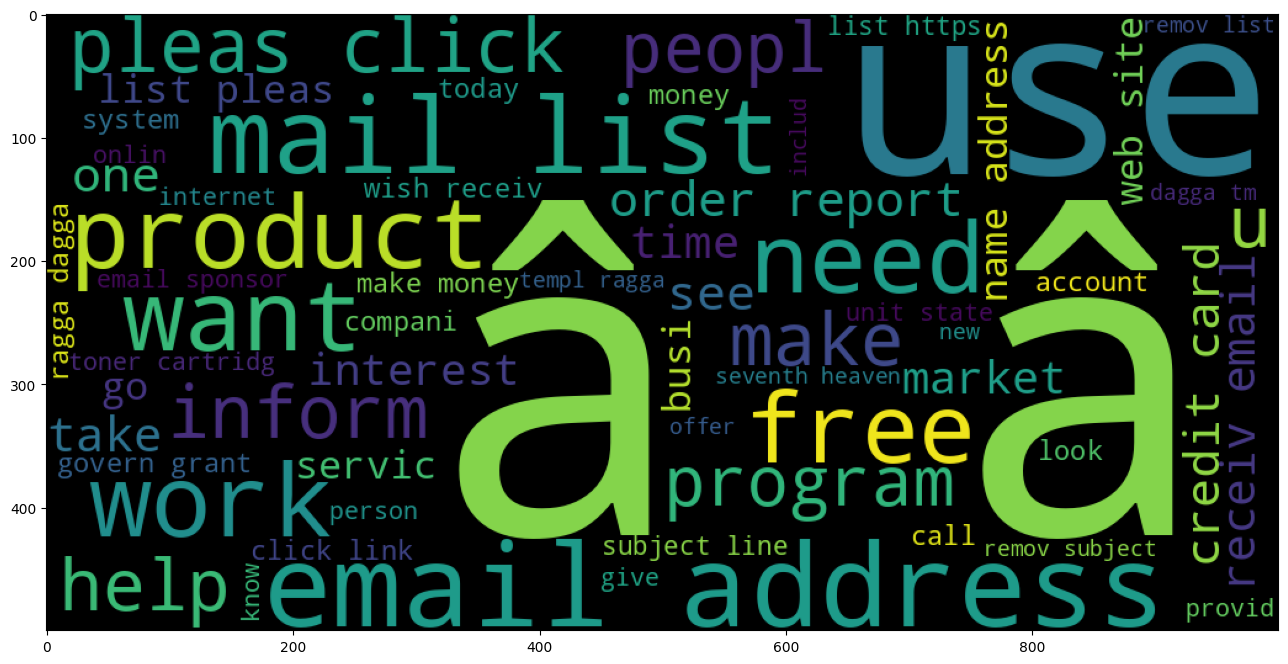

In [25]:
# creating word cloud of spam emails
spam_wc = wc.generate(df[df['Label'] == 1]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(spam_wc)

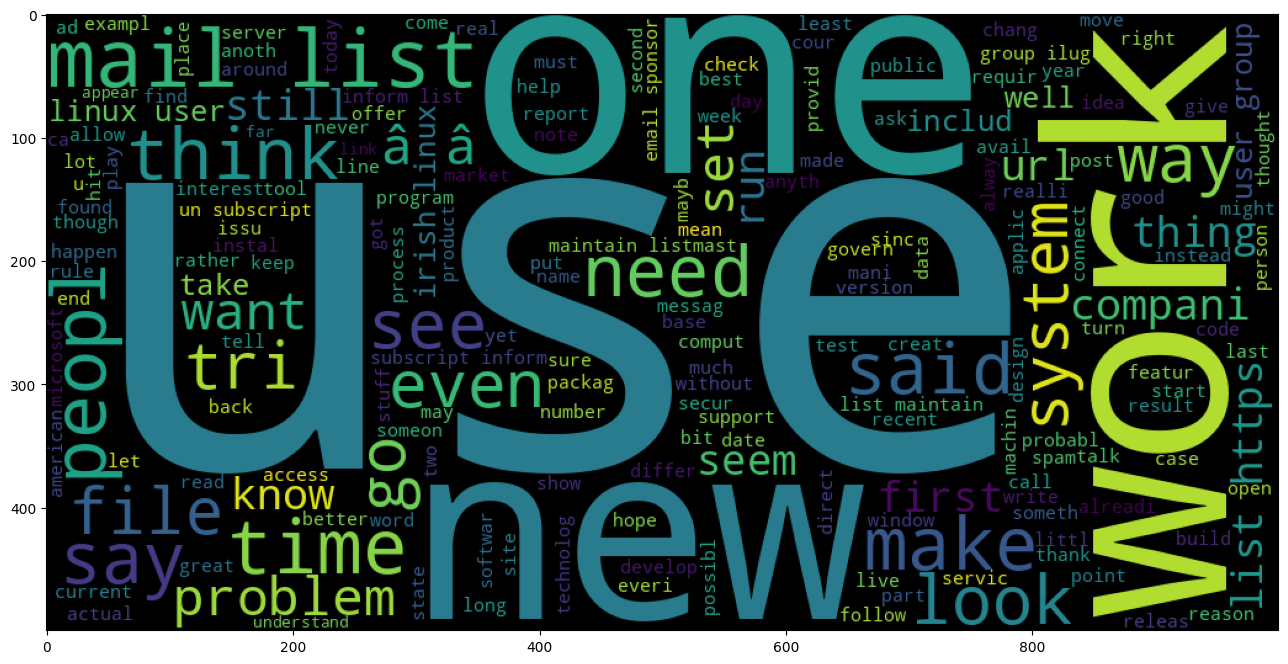

In [26]:
# creating word cloud of ham emails
ham_wc = wc.generate(df[df['Label'] == 0]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)

In [27]:
# creating list of all the words in processed spam emails
spam_corpus = []
for mail in df[df['Label'] == 1]['clean_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

267887

In [29]:
# creating list of all the words in processed ham emails
ham_corpus = []
for mail in df[df['Label'] == 0]['clean_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

519767

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> TRAIN TEST SPLIT </p>

TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).  

Tf-idf is one of the best metrics to determine how significant a term is to a text in a series or a corpus. tf-idf is a weighting system that assigns a weight to each word in a document based on its term frequency (tf) and the reciprocal document frequency (tf) (idf). The words with higher scores of weight are deemed to be more significant.

In [31]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)

# Setting up features and target as x and y
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Label'].values

In [32]:
# Splitting the testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> MODEL SELECTION </p>

In [33]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=0)
xgb = XGBClassifier(n_estimators=50,random_state=0)
sgd = SGDClassifier(random_state=0)
cat = CatBoostClassifier(verbose=0, random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [40]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc,
    'DecisionTree': dtc,
    'LogisticRegression': lrc,
    'RandomForest': rfc,
    'AdaBoost': abc,
    'BaggingClassifier': bc,
    'ExtraTreesClassifier': etc,
    'GradientBoosting': gbdt,
    'XGB': xgb,
    'SGD' : sgd,
    'Catboost' : cat,
    'LGBM' : lgbm
}

In [35]:
# creating a function to train list of algorithms and give accuracy , precision score
def train_classifier(classifiers,x_train,y_train,x_test,y_test):

    classifiers.fit(x_train,y_train)

    y_pred = classifiers.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [36]:
# storing accuracy and precision in list
accuracy_scores = []
precision_scores = []

# training all the models on training data
for name, classifier in classifiers.items():

    current_accuracy,current_precision = train_classifier(classifiers, x_train,y_train,x_test,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision,'\n')

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  GaussianNB
Accuracy -  0.9073614557485525
Precision -  0.8308080808080808 

For  MultinomialNB
Accuracy -  0.9371381306865177
Precision -  0.8983957219251337 

For  BernoulliNB
Accuracy -  0.9412737799834574
Precision -  0.9809523809523809 

For  SVC
Accuracy -  0.9586435070306039
Precision -  0.900990099009901 

For  KNeighbors
Accuracy -  0.39619520264681557
Precision -  0.338768115942029 

For  DecisionTree
Accuracy -  0.8875103391232424
Precision -  0.8005050505050505 

For  LogisticRegression
Accuracy -  0.9346567411083541
Precision -  0.8831168831168831 

For  RandomForest
Accuracy -  0.9371381306865177
Precision -  0.8725 

For  AdaBoost
Accuracy -  0.9263854425144747
Precision -  0.8467153284671532 

For  BaggingClassifier
Accuracy -  0.9313482216708023
Precision -  0.8574938574938575 

For  ExtraTreesClassifier
Accuracy -  0.946236559139785
Precision -  0.8911392405063291 

For  GradientBoosting
Accuracy -  0.9172870140612076
Precision -  0.8702702702702703 

For  XGB
Acc

Data Frame of accuracy and precision of models trained on all features

In [41]:
performance = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance

,Algorithm,Accuracy,Precision
2,BernoulliNB,0.941274,0.980952
13,SGD,0.961125,0.903704
3,SVC,0.958644,0.900990
1,MultinomialNB,0.937138,0.898396
14,Catboost,0.947891,0.893671
10,ExtraTreesClassifier,0.946237,0.891139
6,LogisticRegression,0.934657,0.883117
12,XGB,0.942928,0.880299
15,LGBM,0.946237,0.879607
7,RandomForest,0.937138,0.872500


Data Frame of accuracy and precision of models trained on max_features = 17000

In [42]:
performance_maxf17k = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy_maxf17k':accuracy_scores,'Precision_maxf17k':precision_scores}).sort_values('Precision_maxf17k',ascending=False)
performance_maxf17k

,Algorithm,Accuracy_maxf17k,Precision_maxf17k
2,BernoulliNB,0.941274,0.980952
13,SGD,0.961125,0.903704
3,SVC,0.958644,0.900990
1,MultinomialNB,0.937138,0.898396
14,Catboost,0.947891,0.893671
10,ExtraTreesClassifier,0.946237,0.891139
6,LogisticRegression,0.934657,0.883117
12,XGB,0.942928,0.880299
15,LGBM,0.946237,0.879607
7,RandomForest,0.937138,0.872500


We can clearly see algorithm trained on 17000 features giving us the best result

**Best Performing Models:**
* BernoulliNB
* SGD
* SVC

# HYPERPARAMETER TUNING

*Les paramètres qui définissent l'architecture du modèle sont appelés hyperparamètres, et ainsi ce processus de recherche de l'architecture de modèle idéale est appelé ajustement d'hyperparamètres.
*Les hyperparamètres ne sont pas des paramètres du modèle et ils ne peuvent pas être directement entraînés à partir des données. Les paramètres du modèle sont appris lors de l'entraînement lorsque nous optimisons une fonction de perte en utilisant quelque chose comme la descente de gradient.

*Les paramètres du modèle spécifient comment transformer les données d'entrée en la sortie souhaitée, les hyperparamètres définissent comment notre modèle est réellement structuré. Malheureusement, il n'y a pas de moyen de calculer "quelle direction devrais-je mettre à jour mon hyperparamètre pour réduire la perte ?" (c'est-à-dire les gradients) afin de trouver l'architecture de modèle optimale ; ainsi, nous avons généralement recours à l'expérimentation pour découvrir ce qui fonctionne le mieux.

**Ajustement des hyperparamètres avec Optuna :
Optuna est "une bibliothèque open-source d'optimisation d'hyperparamètres pour automatiser la recherche d'hyperparamètres optimaux". Les principales caractéristiques d'Optuna comprennent "la recherche automatisée d'hyperparamètres optimaux", "l'exploration efficace de grands espaces et l'élagage des essais peu prometteurs pour des résultats plus rapides" et "la parallélisation des recherches d'hyperparamètres sur plusieurs threads ou processus".

**Tuning BernoulliNB**

The first step is to define the objective function for Optuna to maximize or minimize. The objective function should take a “Trial” object as the input and return the score, a float value or a list of float values.

In [43]:
def objective_bnb(trial):
        alpha = trial.suggest_categorical('alpha', [0.7,0.8,0.9,1,1.1,1.2,1.3])
        binarize = trial.suggest_categorical('binarize', [0.0,0.1,0.2,0.3])

        bnb = BernoulliNB(
                                        alpha=alpha,
                                        binarize=binarize
        )
        return cross_val_score(bnb, x_train, y_train, n_jobs=-1, verbose=0, scoring='precision').mean()

The next step is to use the objective function to create a “Study” object and then optimize it.

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_bnb, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-15 14:11:58,177] A new study created in memory with name: no-name-8336461f-e05e-4cc7-b3ce-01737bfb4bf0
[I 2023-08-15 14:12:10,759] Trial 0 finished with value: 0.9639960766496888 and parameters: {'alpha': 1.2, 'binarize': 0.1}. Best is trial 0 with value: 0.9639960766496888.
[I 2023-08-15 14:12:20,715] Trial 1 finished with value: 0.6 and parameters: {'alpha': 1.3, 'binarize': 0.3}. Best is trial 0 with value: 0.9639960766496888.
[I 2023-08-15 14:12:26,324] Trial 2 finished with value: 0.9784642131583059 and parameters: {'alpha': 1.1, 'binarize': 0.0}. Best is trial 2 with value: 0.9784642131583059.
[I 2023-08-15 14:12:32,170] Trial 3 finished with value: 1.0 and parameters: {'alpha': 1, 'binarize': 0.3}. Best is trial 3 with value: 1.0.
[I 2023-08-15 14:12:37,197] Trial 4 finished with value: 0.9795639423594343 and parameters: {'alpha': 1, 'binarize': 0.2}. Best is trial 3 with value: 1.0.
[I 2023-08-15 14:12:43,369] Trial 5 finished with value: 0.9477211242867056 and param

Accuracy: 1.0
Best hyperparameters: {'alpha': 1, 'binarize': 0.3}


In [45]:
bnb = BernoulliNB(alpha=0.9, binarize=0.3)
bnb.fit(x_train,y_train)

bnb_pred = bnb.predict(x_test)
print('Accuracy:',accuracy_score(y_test,bnb_pred))
print('Precision:',precision_score(y_test,bnb_pred))

Accuracy: 0.7262200165425972
Precision: 1.0


Nous avons réussi à augmenter la précision mais l'exactitude a diminué. J'ai beaucoup expérimenté et j'ai constaté qu'un des scores diminue si j'essaie d'augmenter les autres. Donc, je ne vais pas régler ce modèle car il me donne de meilleurs résultats de cette manière.

**Tuning SGDClassifier:**

In [46]:
def objective_sgd(trial):
        loss = trial.suggest_categorical('loss', ['hinge','log_loss','log','modified_huber','squared_hinge','perceptron'])
        penalty = trial.suggest_categorical('penalty', ['l2','l1','elasticnet'])
        l1_ratio = trial.suggest_categorical('l1_ratio', [0.2,0.5,0.8])
        max_iter = trial.suggest_categorical('max_iter', [100,500,1000])


        sgd = SGDClassifier(
                            early_stopping=True,
                            random_state=0,
                            loss=loss,
                            penalty=penalty,
                            l1_ratio=l1_ratio,
                            max_iter=max_iter
        )
        return cross_val_score(sgd, x_train, y_train, n_jobs=-1, verbose=0, scoring='precision').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_sgd, n_trials=20)

trial_sgd = study.best_trial

print('Accuracy: {}'.format(trial_sgd.value))
print("Best hyperparameters: {}".format(trial_sgd.params))

[I 2023-08-15 14:15:04,964] A new study created in memory with name: no-name-e3d4a583-be8c-4bc3-a1f6-baaed3004e83
[I 2023-08-15 14:15:12,041] Trial 0 finished with value: 0.9339684439907998 and parameters: {'loss': 'squared_hinge', 'penalty': 'l2', 'l1_ratio': 0.5, 'max_iter': 500}. Best is trial 0 with value: 0.9339684439907998.
[I 2023-08-15 14:15:23,540] Trial 1 finished with value: 0.9252125720055387 and parameters: {'loss': 'perceptron', 'penalty': 'l2', 'l1_ratio': 0.2, 'max_iter': 100}. Best is trial 0 with value: 0.9339684439907998.
[I 2023-08-15 14:15:46,391] Trial 2 finished with value: 0.8834201881034248 and parameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'l1_ratio': 0.2, 'max_iter': 1000}. Best is trial 0 with value: 0.9339684439907998.
[I 2023-08-15 14:16:08,564] Trial 3 finished with value: 0.885838312943928 and parameters: {'loss': 'squared_hinge', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'max_iter': 500}. Best is trial 0 with value: 0.9339684439907998.


In [ ]:
sgd = SGDClassifier(loss='perceptron',penalty='l2',l1_ratio=0.5,max_iter=1000)
sgd.fit(x_train,y_train)

sgd_pred = sgd.predict(x_test)
print('Accuracy:',accuracy_score(y_test,sgd_pred))
print('Precision:',precision_score(y_test,sgd_pred))

Accuracy: 0.946236559139785
Precision: 0.9904761904761905


we have increased the precision and accuracy is also looking good.

I am giving more importance to precision cause , precision means number of ham emails classified as spam and accuracy means number of correctly classified emails.  

I am okay with few spam emails not classified as spam, but i don't want any ham email classified as spam cuase it might be very important. So thats why i wanted precision very high as well as accuracy

<h2 style="background-color:#562F5E;font-family:verdana;color:white;font-size:200%;text-align:center;letter-spacing:0.5px;padding: 10px"> If You Liked The NoteBook, Please Upvote✌  </h2>